In [92]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools
import time
import math
import sys

## Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 
import scipy.stats as stats
from scipy.stats import wasserstein_distance

## Data Wrangling
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
orig_cmap = plt.cm.PuBu

## snap
color_map =["grey"]
mpl.rcParams['figure.dpi'] = 300

In [82]:
## supporting functions
from support.preprocessing import sort_adj, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, pad_attr, unpad_attr, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single_features, generate_manifold_features
from support.latent_space import vis2D, visDistr
from support.comparing import compare_manifold_adjacency, compare_topol_manifold
from support.plotting import shiftedColorMap

## graph sampling
from sampling import ForestFire, Metropolis_Hastings, Random_Walk, Snowball, Ties, Base_Samplers

In [62]:
edge_df = pd.read_csv("/Users/niklasstoehr/Programming/thesis/4_real_attr/data/amazon/edges_sample.csv", header = None, skiprows=1) 
edge_list = [(int(val[0]), int(val[1])) for val in list(edge_df.values)]
#print(edge_list)

         0     1
0        1     9
1        1   436
2        1   545
3        1    15
4        1   259
5        9   436
6        9    15
7        9   259
8        9   752
9      436    15
10     436   259
11     436   752
12     545    15
13     545   259
14     545   752
15       4   198
16       4   464
17       4   602
18     198   296
19     198   634
20     198   750
21     464   334
22     464   478
23     464   484
24     464   565
25     602   553
26     602   566
27     602   612
28     602  1742
29       5   171
...    ...   ...
5256  2534  2518
5257  2574  1943
5258  2577  2679
5259  2585  2633
5260  2597  2670
5261  2598  2257
5262  2608  1988
5263  2613  1904
5264  2613  2626
5265  2621  1973
5266  2622  2106
5267  2632  2602
5268  2635  1877
5269  2638  2653
5270  2667  2412
5271  2679  2478
5272  2685  2524
5273  2698  2699
5274  2698  2701
5275  2699  2701
5276  2707  1753
5277  2708  2345
5278     0  2708
5279  2708  2709
5280  2708  2710
5281  2708  2711
5282  2708  27

In [66]:
g_complete = nx.Graph()
g_complete.add_edges_from(edge_list)
a_complete = nx.adjacency_matrix(g_complete)
print(g_complete.nodes())

[1, 9, 436, 545, 15, 259, 752, 4, 198, 464, 602, 296, 634, 750, 334, 478, 484, 565, 553, 566, 612, 1742, 5, 171, 251, 13, 156, 85, 118, 514, 14, 483, 579, 1235, 252, 552, 32, 233, 243, 269, 385, 394, 401, 438, 444, 614, 709, 737, 747, 1117, 575, 1007, 8, 1032, 1112, 617, 2047, 2572, 158, 556, 2355, 2361, 2108, 2497, 300, 16, 81, 130, 153, 235, 254, 255, 323, 400, 539, 702, 2045, 23, 189, 1205, 1410, 1974, 2166, 2194, 2221, 2364, 2447, 2452, 164, 1729, 1384, 748, 1816, 2671, 1177, 161, 1028, 968, 1645, 2509, 1251, 1252, 428, 403, 488, 1037, 1690, 1739, 2310, 639, 19, 128, 867, 891, 1933, 746, 123, 125, 2229, 2401, 577, 1913, 2025, 20, 572, 75, 425, 1763, 2332, 2496, 2695, 21, 268, 26, 335, 641, 733, 460, 1791, 2258, 192, 416, 524, 2335, 248, 1768, 1769, 2445, 457, 779, 1182, 1898, 1297, 1749, 2100, 2456, 2654, 550, 570, 673, 1561, 110, 57, 1432, 1004, 2147, 2183, 27, 1130, 2613, 810, 815, 920, 1081, 1191, 1223, 28, 533, 29, 587, 1607, 1719, 31, 232, 286, 680, 1149, 2277, 487, 33, 1356, 

In [84]:
import random
import networkx as nx
import numpy as np
import time


class Base_Samplers():

    def __init__(self, g_complete, a_complete):
        self.g_complete = g_complete
        self.n_complete = len(g_complete)
        self.a_complete = a_complete

    def biased_random_walk(self, n, p, q):

        g = nx.Graph()

        node_1 = np.random.choice(self.g_complete.nodes())
        g.add_node(node_1)

        neigh_1 = [n for n in self.g_complete.neighbors(node_1)]
        node_2 = np.random.choice(neigh_1)
        g.add_node(node_2)
        g.add_edge(node_1, node_2)

        timeout = time.time() + 0.2

        while len(g) < n and time.time() < timeout:

            neigh_2 = [n for n in self.g_complete.neighbors(node_2)]
            neigh_2_prob = np.zeros((len(neigh_2)))

            if len(neigh_2) <= 1:  ## break the process if only neighbor is origin
                break

            for i, neigh in enumerate(neigh_2):

                if neigh == node_1:
                    neigh_2_prob[i] = 1 / p  ## go back prob -> step back

                elif self.g_complete.has_edge(node_1, neigh):
                    neigh_2_prob[i] = 1  ## common neighbor prob -> community exploration

                elif self.g_complete.has_edge(node_1, neigh) == False:
                    neigh_2_prob[i] = 1 / q  ## no common neighbor prob -> free exploration

            neigh_2_prob = neigh_2_prob / sum(neigh_2_prob)  ## normalize probability
            node_3 = np.random.choice(neigh_2, p=neigh_2_prob)

            g.add_node(node_3)
            g.add_edge(node_2, node_3)

            node_1 = node_2  ## update node 1 and node 2 for next iteration
            node_2 = node_3

        return g


-- n_max should be >= 19 --
-- function get_graph takes 0.00836 secs --


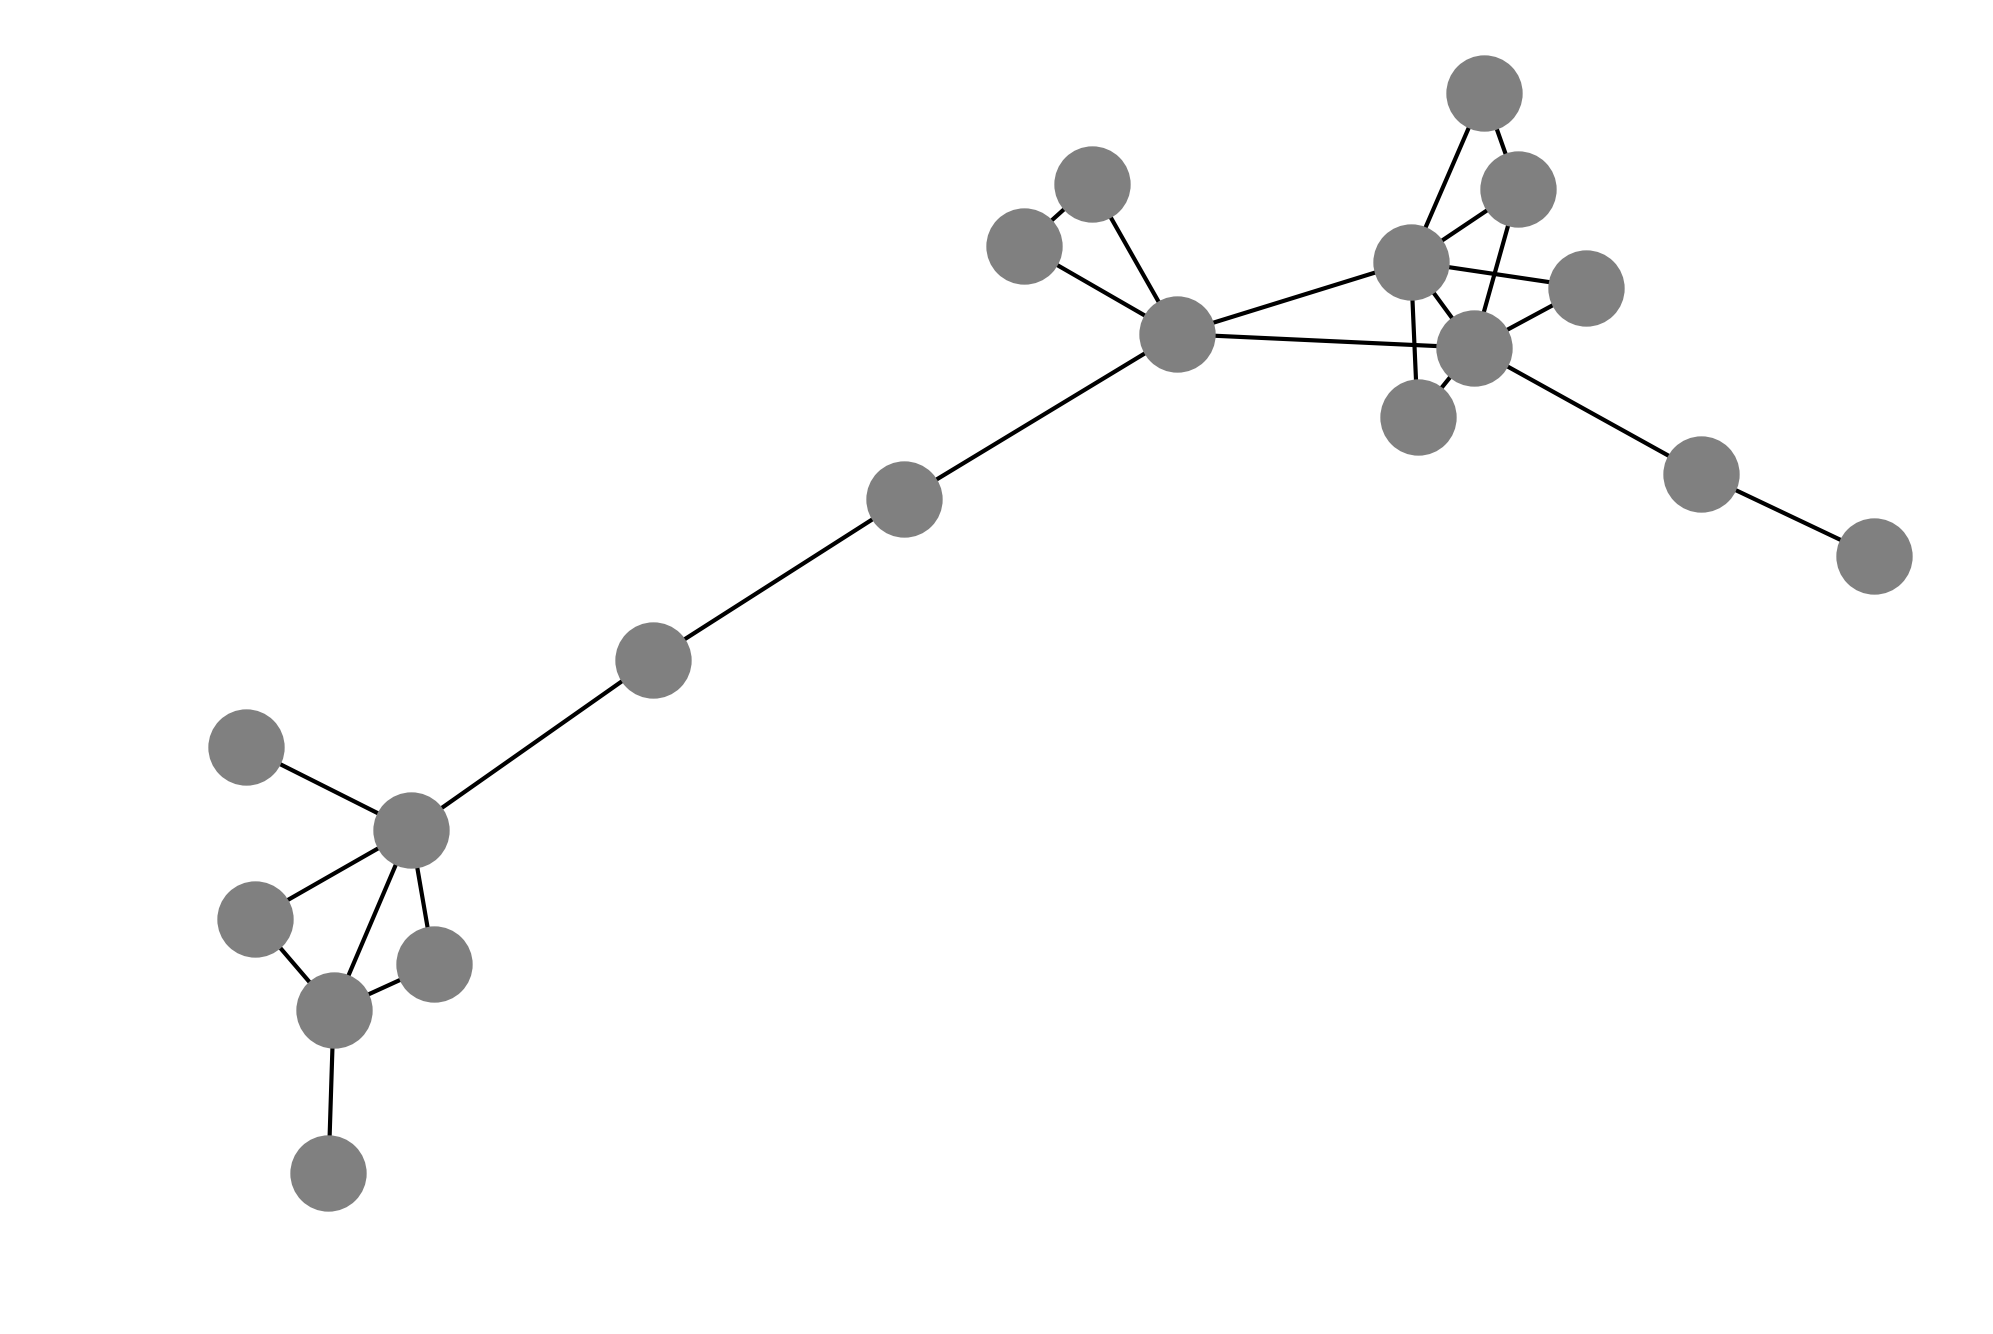

In [307]:
sampleArgs = {"sample": "biased_random_walk", "jump_bias": "random_walk_induced_graph_sampling", "n": 19, "p": 20.0, "q": 100.0, "source_starts": 2, "source_returns": 4, "depth": 2}

##exact_n: forestfire, random_walk_induced_graph_sampling, random_walk_sampling_with_fly_back, adjacency, select
##approx_n: snowball, bfs, walk, jump

def get_graph(sampleArgs,g_complete,a_complete):
    
    if sampleArgs["sample"] == "biased_random_walk":
        sampler = Base_Samplers(g_complete,a_complete)
        #sampler = Base_Samplers(g_complete,a_complete)
        g = sampler.biased_random_walk(sampleArgs["n"], sampleArgs["p"], sampleArgs["q"])
    
    #nx.set_node_attributes(g, node_attr_dict, "citations")
    #f = list(nx.get_node_attributes(g,'citations').values())
    return g

start_time = time.time()
g = get_graph(sampleArgs, g_complete, a_complete)

print("-- n_max should be >=", len(g), "--")
print("-- function get_graph takes %s secs --" % round((time.time() - start_time),  5))

if len(g) <= 200:
    nx.draw(g, node_color = color_map, with_labels = False)

[0, 1, 2, 3, 4, 5, 6, 9, 17, 7, 13, 8, 10, 11, 12, 16]


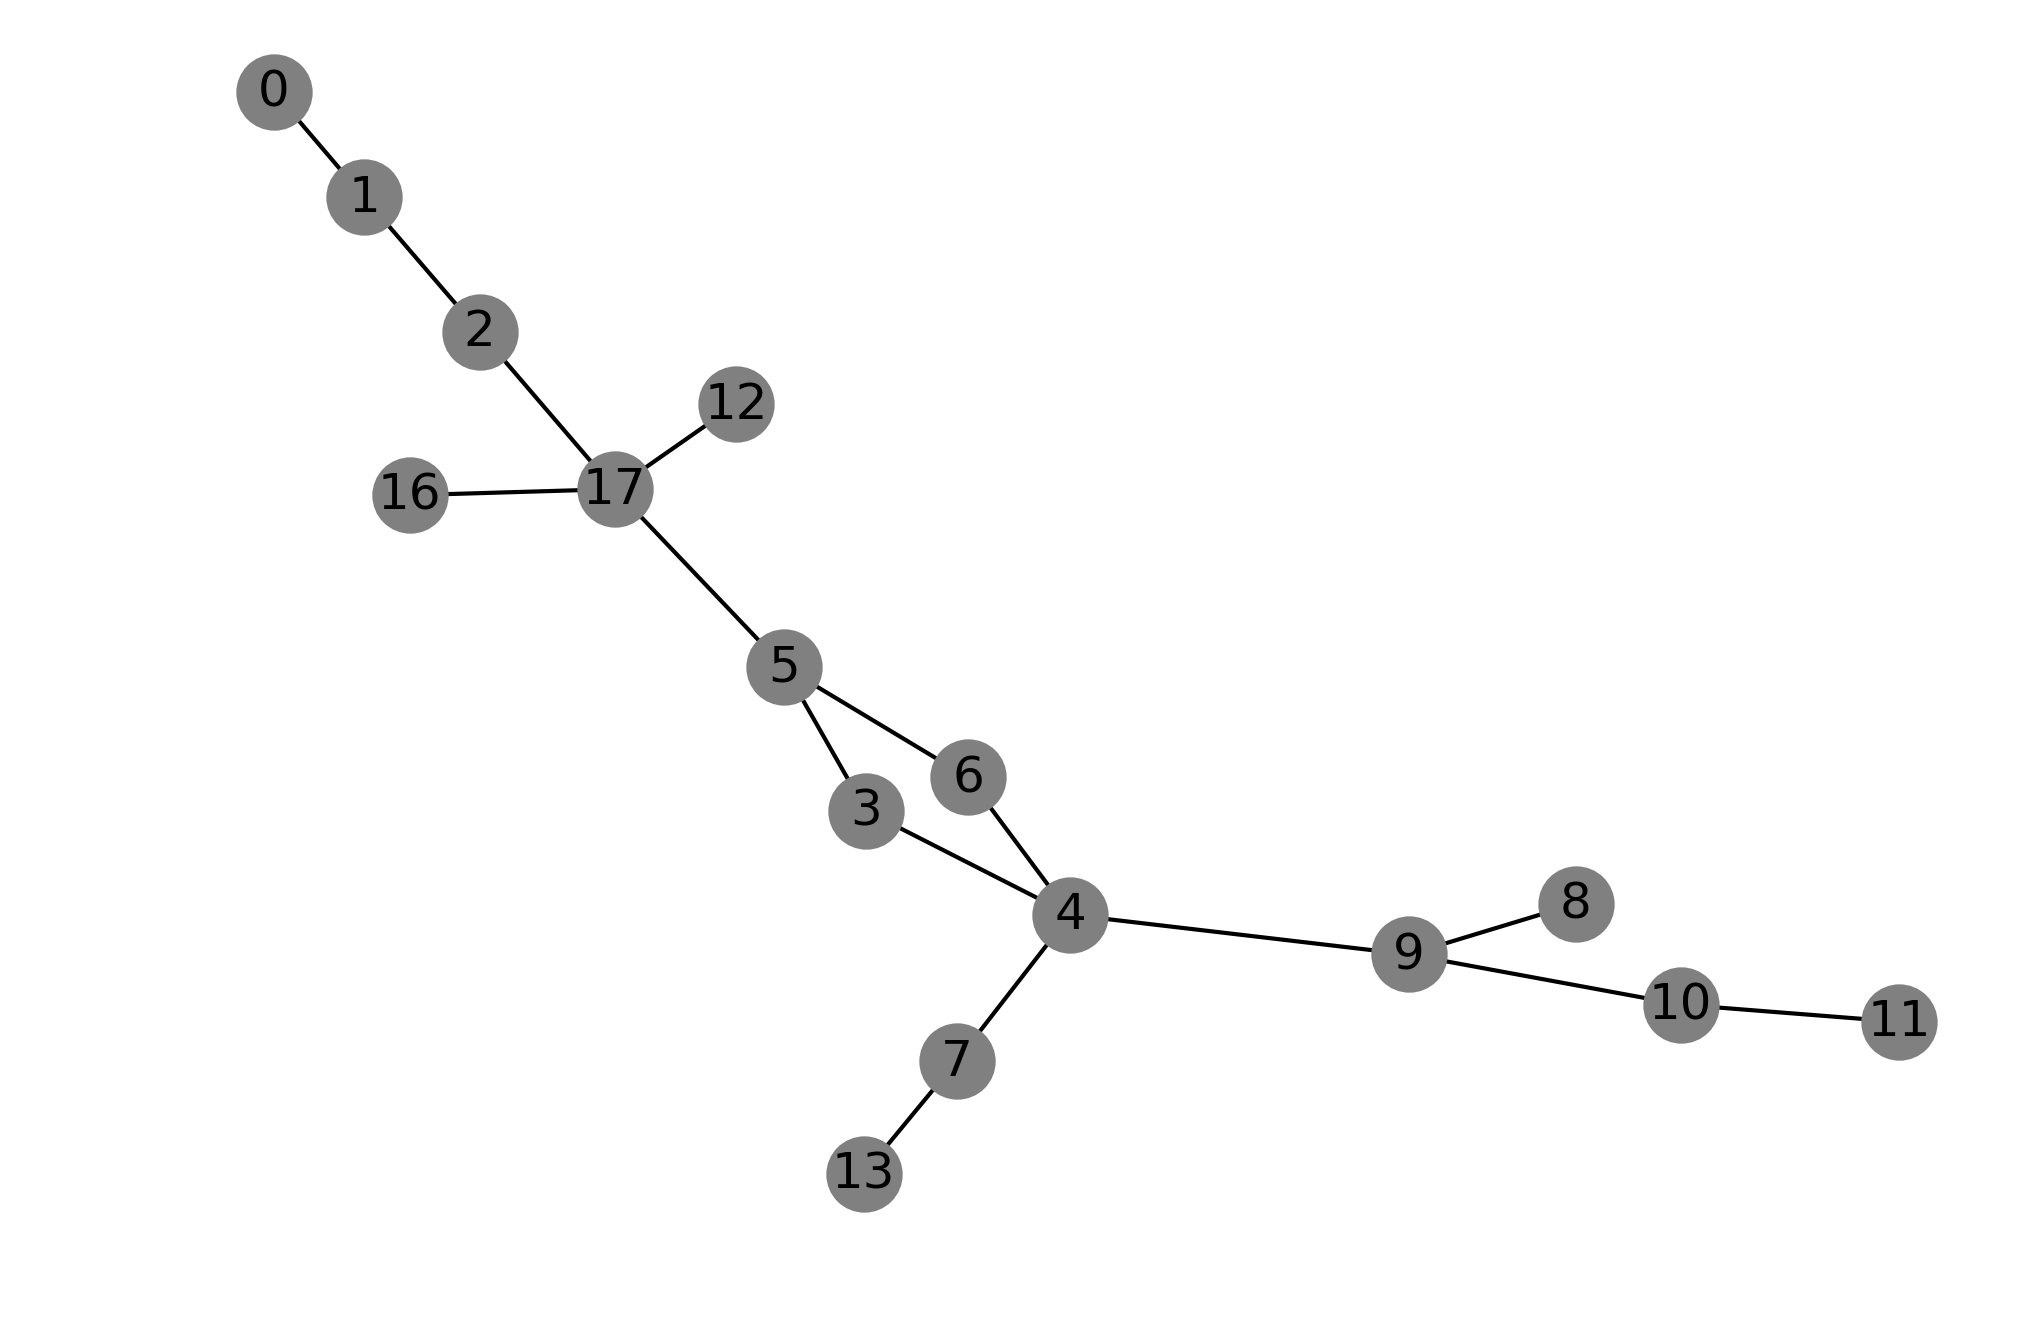

In [331]:
edge_list= [(0,1), (1,2), (3,4), (3,5), (5,6), (6,4), (9,4), (17,2), (7,4), (7,13), (8,9), (9,10), (10,11), (17,2), (12,17), (17,16), (10,11), (5,17)]
#node_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#draw_kamada_kawai
g = nx.Graph()
g.add_edges_from(edge_list)
#g.add_nodes_from(node_list)
#g = nx.random_graphs.erdos_renyi_graph(30, 1.0, seed=None)
nx.draw(g, node_color = color_map, with_labels = True)
print(g.nodes())

In [336]:
print(g.nodes())

[0, 1, 2, 3, 4, 5, 6, 9, 17, 7, 13, 8, 10, 11, 12, 16]


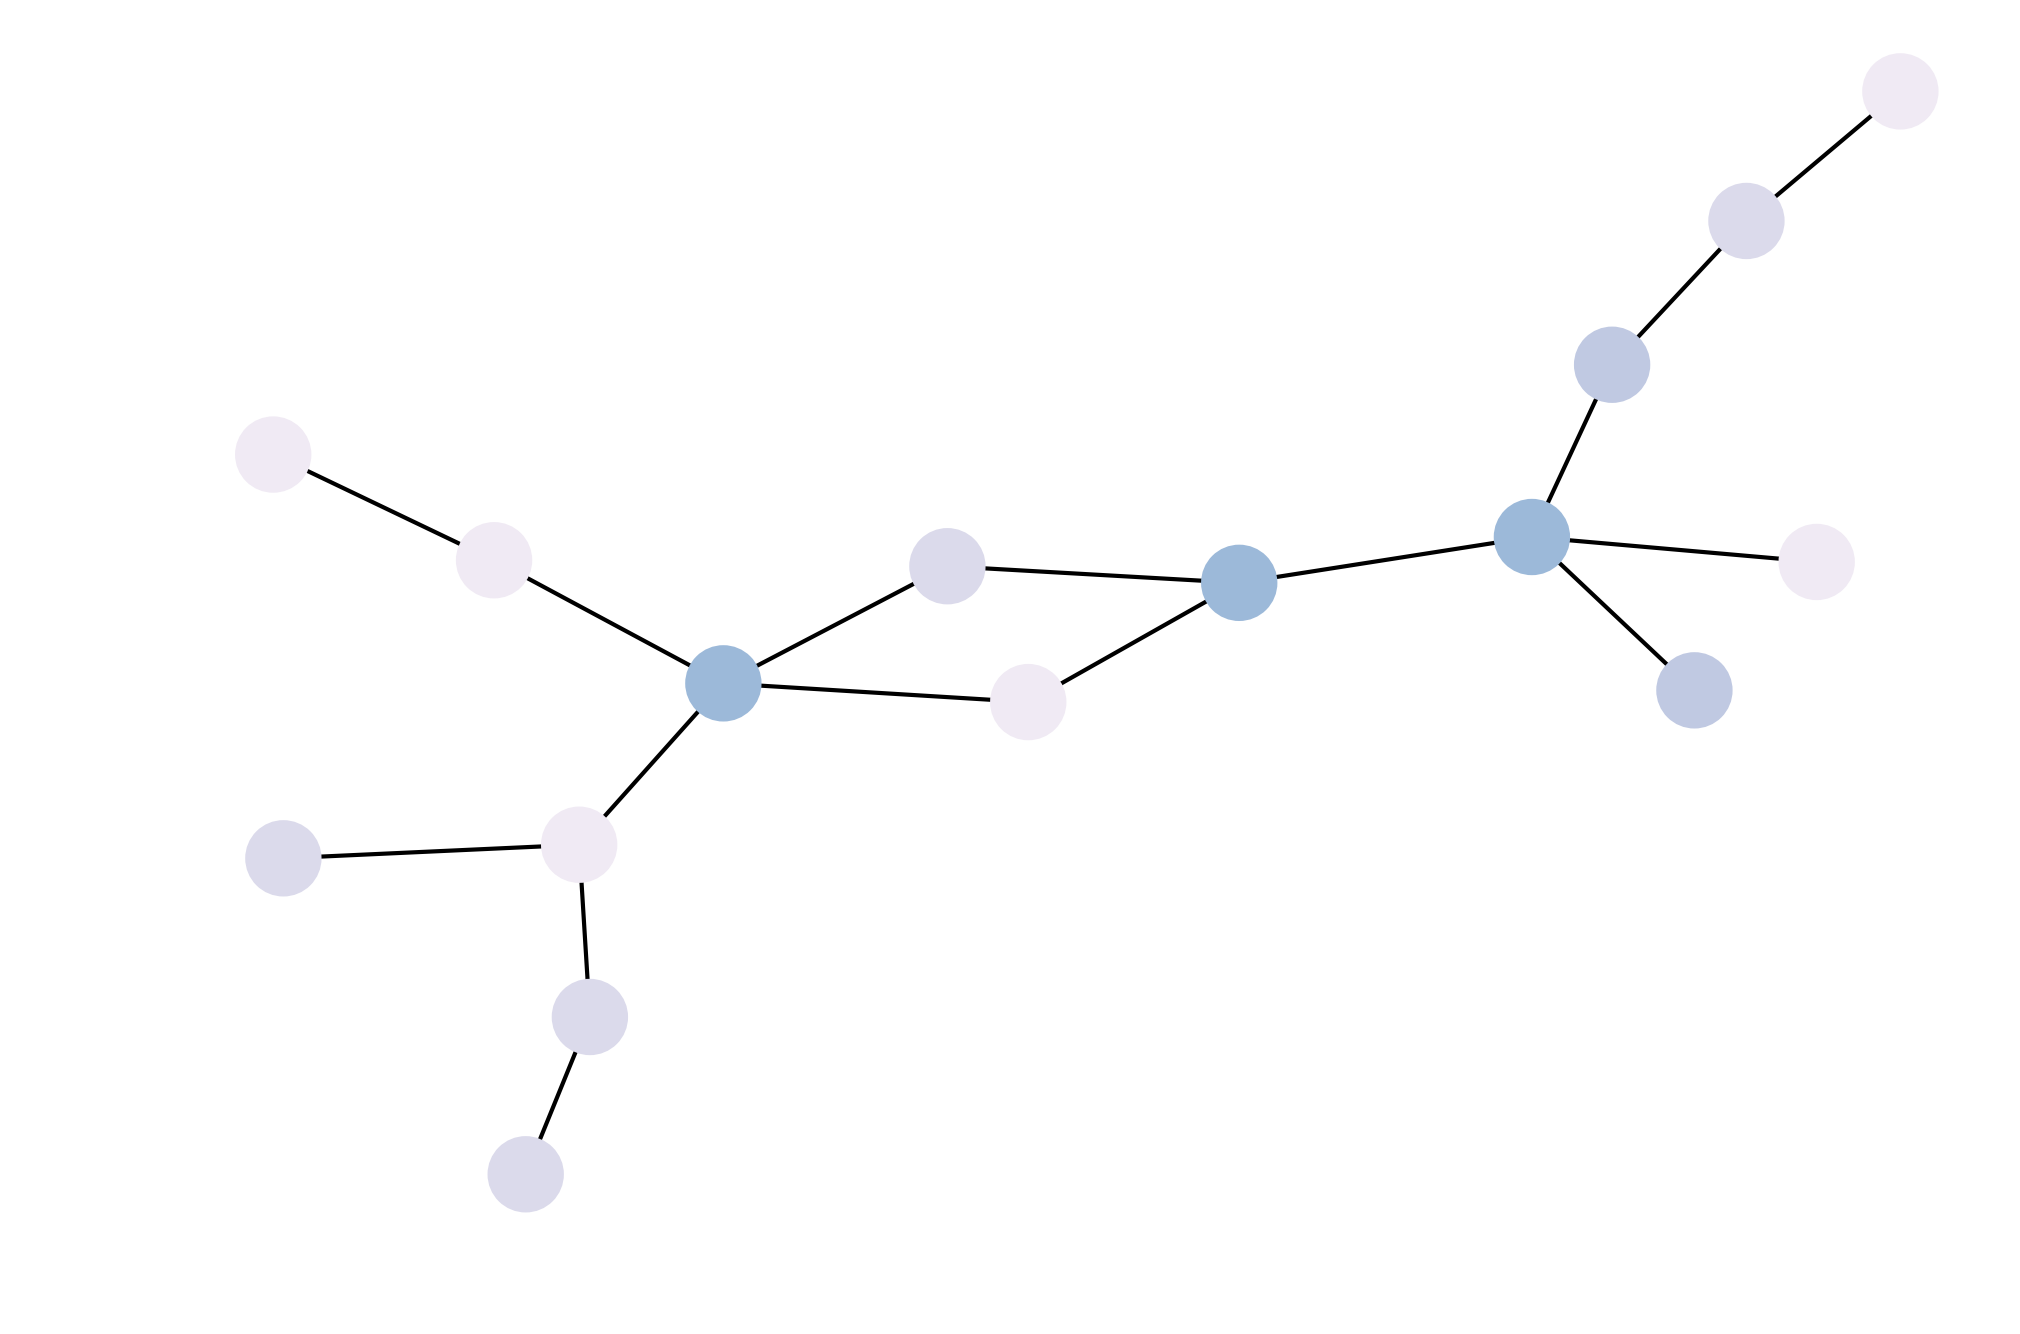

In [343]:
f = [0.1,0.2,0.3,0.2,0.4,0.4,0.1,0.1,0.4,0.1,0.1,0.2,0.2,0.2,0.3,0.1]
#f = [0.7,0.5,0.7,0.7,0.6,0.9,0.6,0.8,0.7]
orig_cmap = plt.cm.PuBu
fixed_cmap = shiftedColorMap(orig_cmap, start=min(f), midpoint=0.5, stop=max(f), name='fixed')
nx.draw_kamada_kawai(g, node_color=f, font_color='white', cmap = fixed_cmap, with_labels = False)